In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from matplotlib import rcParams
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_absolute_error

Поскольку товары не должны превышать стоимости товаров конкурентов более чем на 20%, было принято решение исследовать среднее значение по товару в городе. То есть мы усредняем стоимость товара по всем конкурентам, которые расположены в городе.

In [7]:
comp = pd.read_parquet(r"..\all_data\main_data_parq\df_competitors.parquet")
rec = comp.groupby(["place","product","date"])["price"].mean().reset_index(name = 'mean_of_comp_prices')
rec = rec.set_index('date')

In [8]:
rec

,place,product,mean_of_comp_prices
date,,,
2216-01-02,Анор Лондо,Целебные травы,4.210000
2216-01-03,Анор Лондо,Целебные травы,4.046667
2216-01-04,Анор Лондо,Целебные травы,3.980000
2216-01-05,Анор Лондо,Целебные травы,3.903333
2216-01-06,Анор Лондо,Целебные травы,3.980000
...,...,...,...
2218-09-22,Фалькония,Эстус,15.515000
2218-09-23,Фалькония,Эстус,14.690000
2218-09-24,Фалькония,Эстус,15.016667


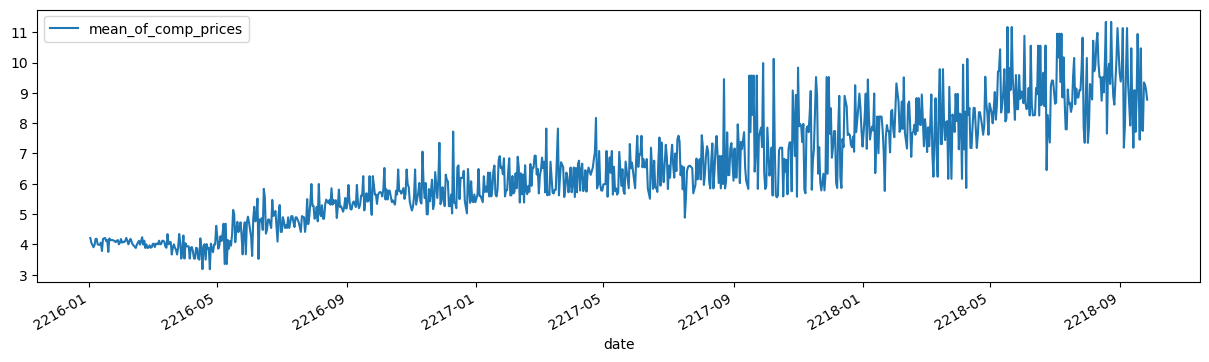

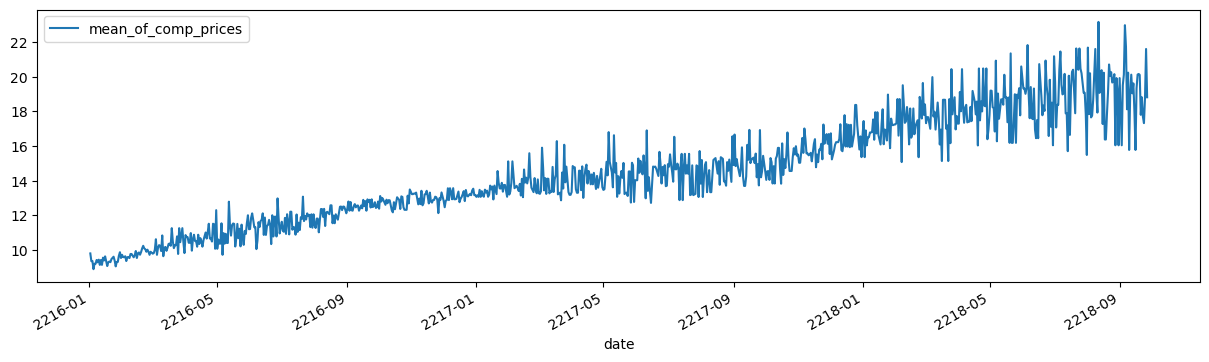

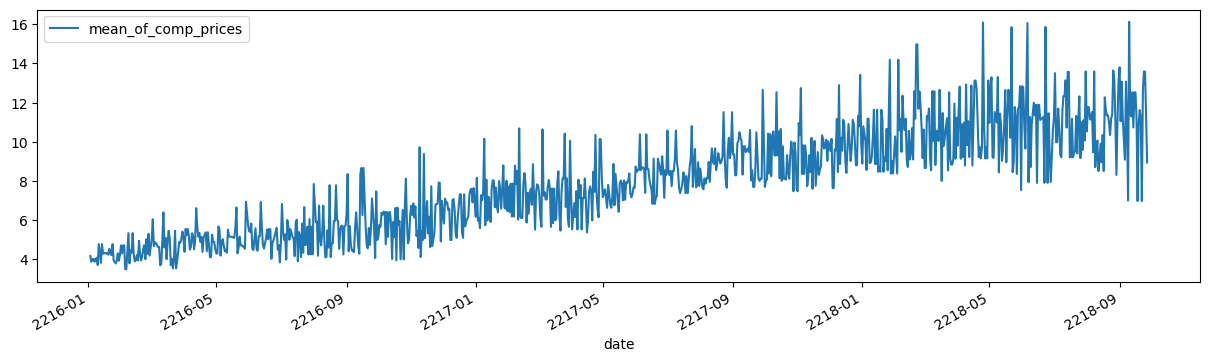

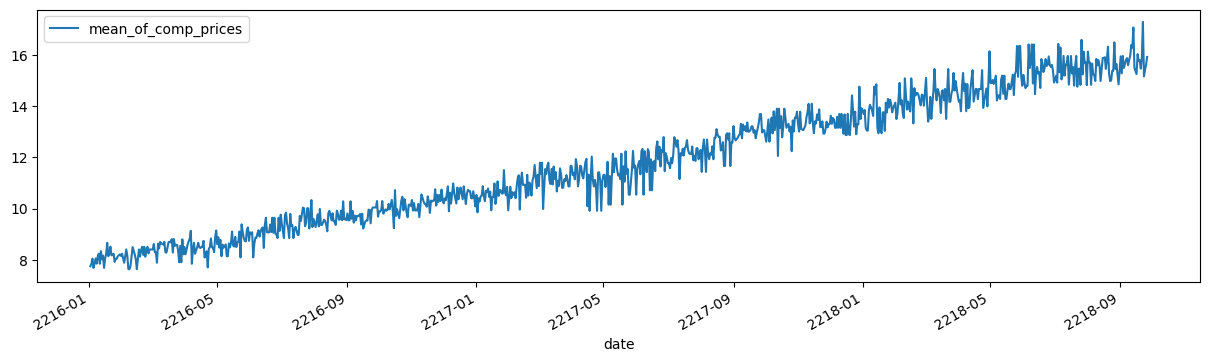

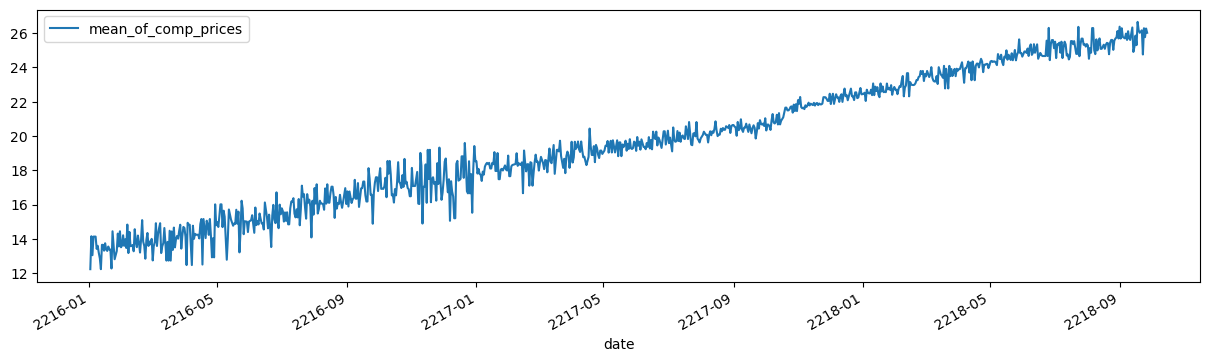

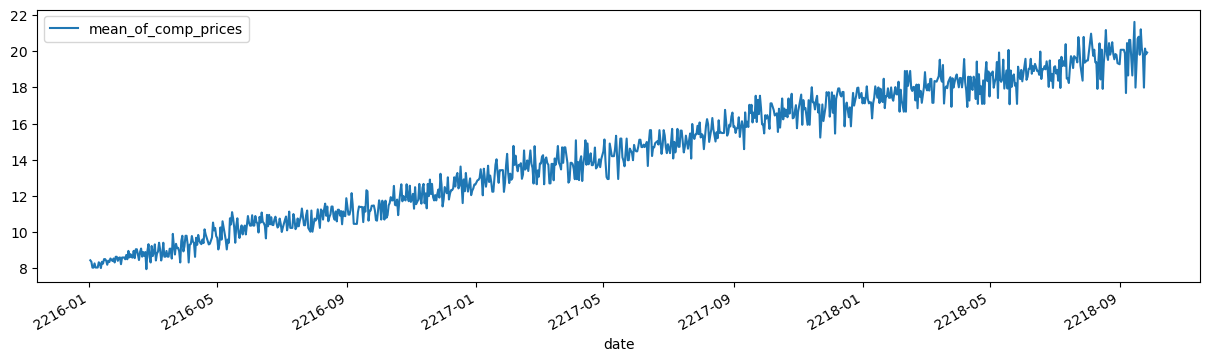

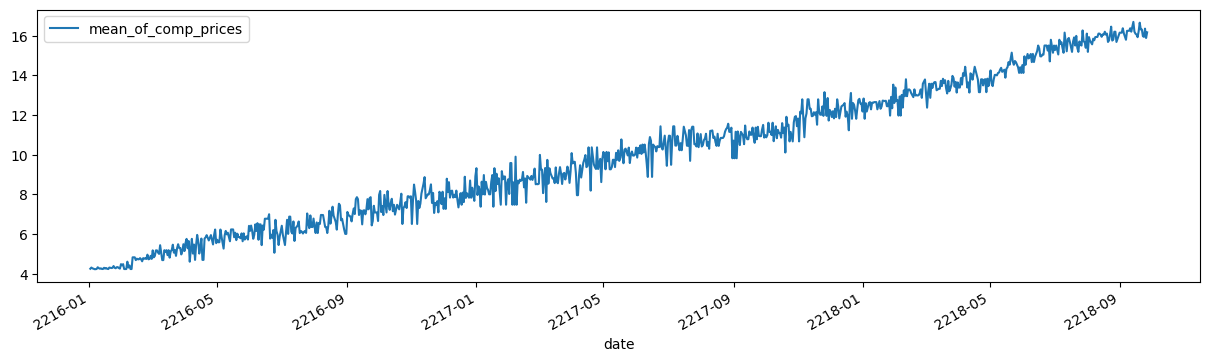

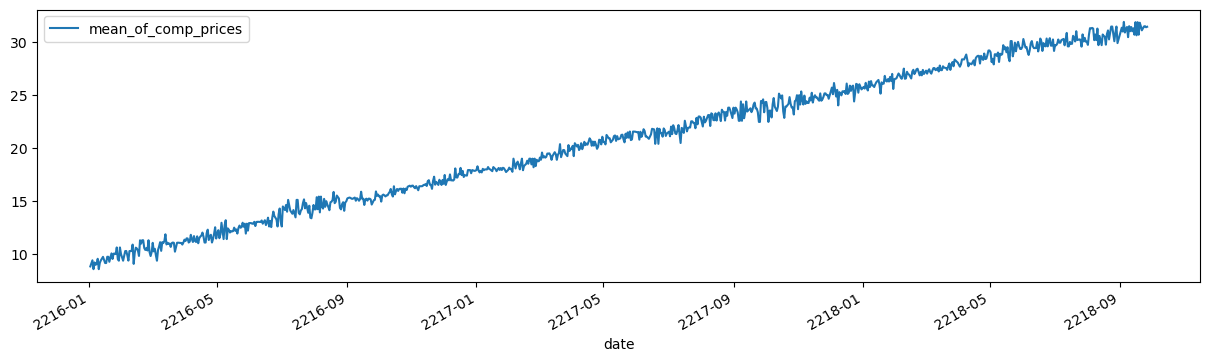

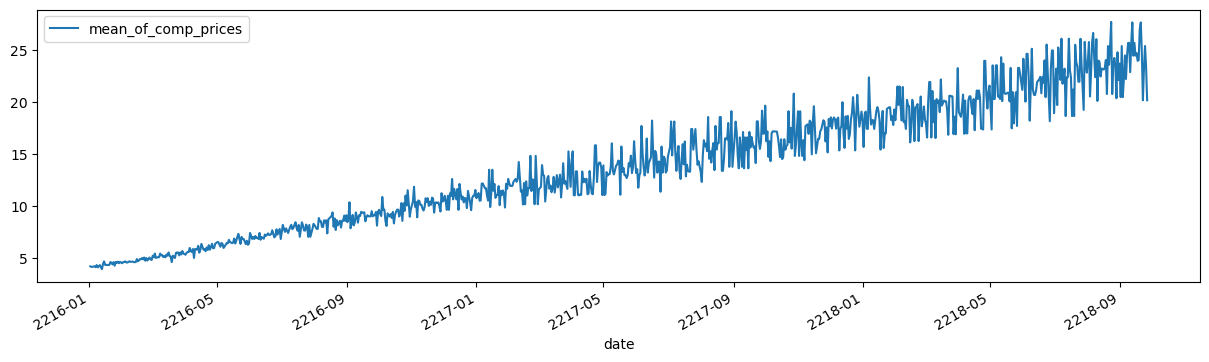

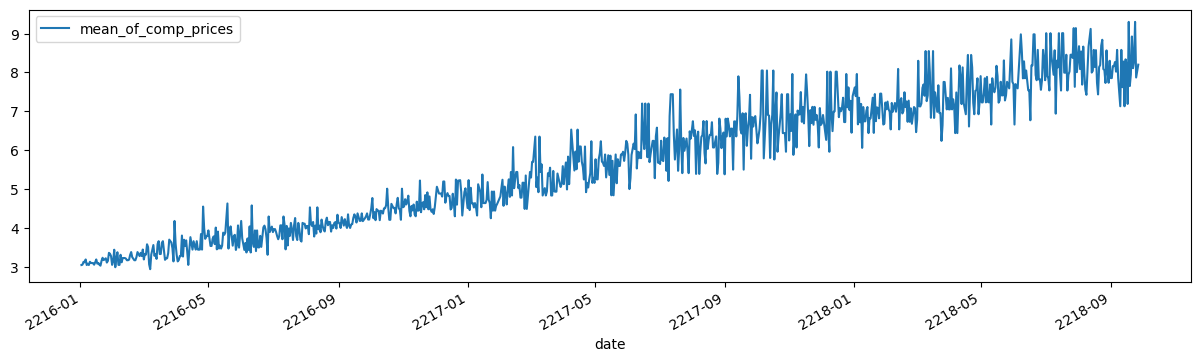

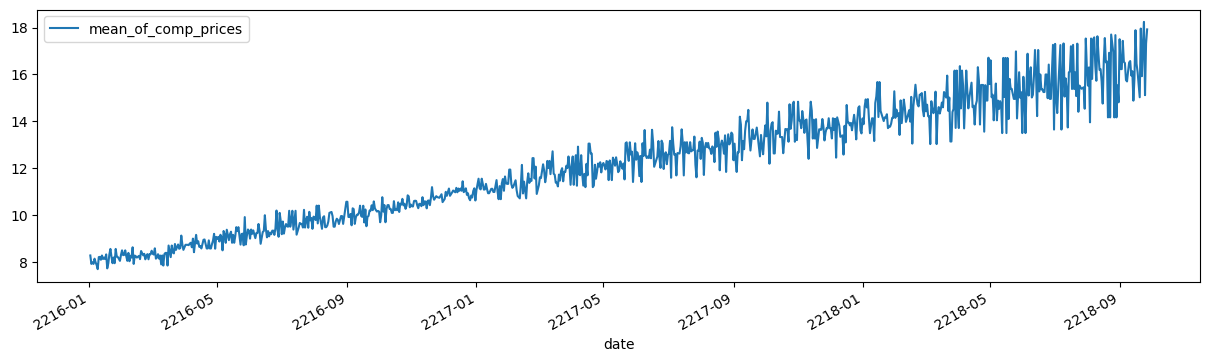

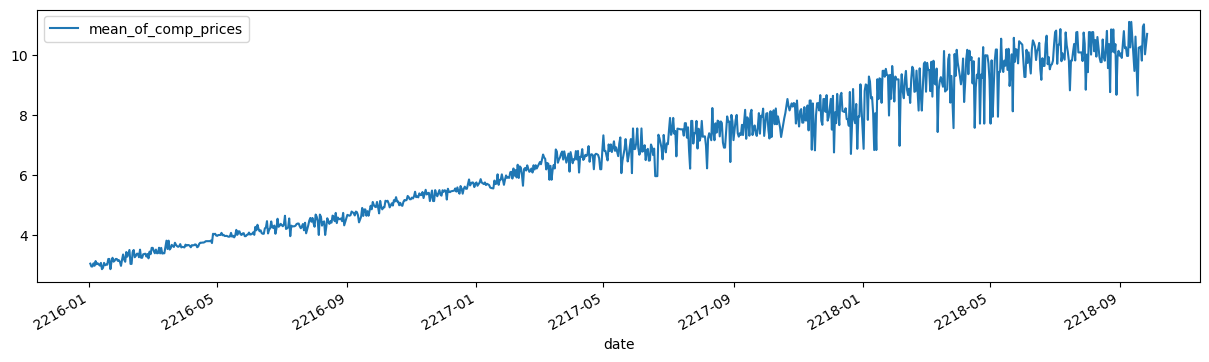

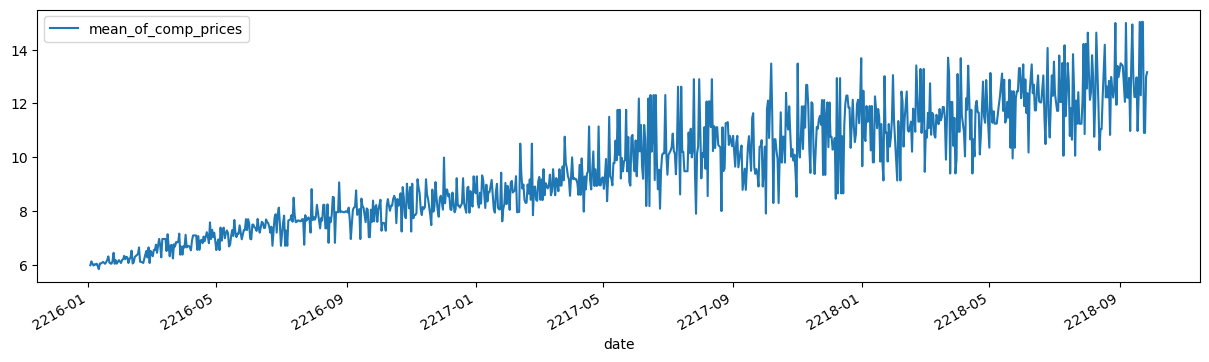

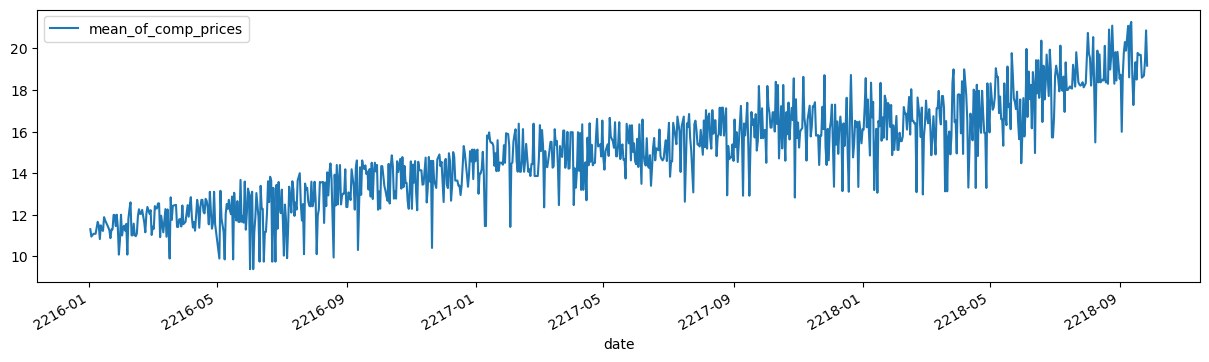

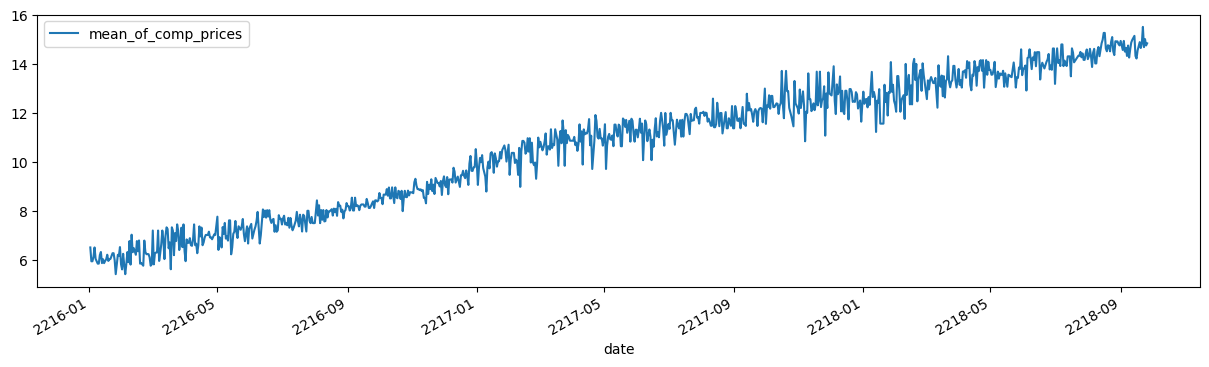

In [9]:
for places in rec.place.unique():
    for products in rec['product'].unique():
        lin = ((rec.place == places) & ( rec['product'] == products))
        rec[lin].plot(figsize = (15,4))

Форма графиков напоминает линейную зависимость, поэтому для обучения воспользуемся моделью LinearRegression.

In [10]:
rec['month'] =rec.index.month 
rec['year'] =rec.index.year 
rec['dates'] = rec.index.day
rec

,place,product,mean_of_comp_prices,month,year,dates
date,,,,,,
2216-01-02,Анор Лондо,Целебные травы,4.210000,1,2216,2
2216-01-03,Анор Лондо,Целебные травы,4.046667,1,2216,3
2216-01-04,Анор Лондо,Целебные травы,3.980000,1,2216,4
2216-01-05,Анор Лондо,Целебные травы,3.903333,1,2216,5
2216-01-06,Анор Лондо,Целебные травы,3.980000,1,2216,6
...,...,...,...,...,...,...
2218-09-22,Фалькония,Эстус,15.515000,9,2218,22
2218-09-23,Фалькония,Эстус,14.690000,9,2218,23
2218-09-24,Фалькония,Эстус,15.016667,9,2218,24


In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from matplotlib import rcParams
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

,place,product,mean_of_comp_prices,month,year,dates
date,,,,,,
2216-01-02,Анор Лондо,Целебные травы,4.210000,1,2216,2
2216-01-03,Анор Лондо,Целебные травы,4.046667,1,2216,3
2216-01-04,Анор Лондо,Целебные травы,3.980000,1,2216,4
2216-01-05,Анор Лондо,Целебные травы,3.903333,1,2216,5
2216-01-06,Анор Лондо,Целебные травы,3.980000,1,2216,6
...,...,...,...,...,...,...
2218-09-22,Фалькония,Эстус,15.515000,9,2218,22
2218-09-23,Фалькония,Эстус,14.690000,9,2218,23
2218-09-24,Фалькония,Эстус,15.016667,9,2218,24


In [17]:
for places in rec.place.unique():
    for products in rec['product'].unique():
        lin = ((rec.place == places) & ( rec['product'] == products))
        X_train, X_test,y_train, y_test = train_test_split(rec[lin].loc[:,~rec[lin].columns.isin(['mean_of_comp_prices','place','product','weekday'])],
                                                  rec[lin]['mean_of_comp_prices'],
                                                   test_size = 0.35,
                                                   random_state=42)
        lrr = LinearRegression().fit(X_train,y_train)
        print("R^2", lrr.score(X_test,y_test))
        pred_test = lrr.predict(X_test)
        pred_train =lrr.predict(X_train)
        print("MSE", np.sqrt(mean_squared_error(y_test, pred_test)))
        print(pd.DataFrame(lrr.coef_, X_train.columns, columns=["coef"]).sort_values(by="coef", ascending=False))
        print("____________")

R^2 0.805976589057047
MSE 0.7737265892621028
           coef
year   2.048481
month  0.177807
dates  0.007540
____________
R^2 0.8866426812506149
MSE 1.014756366677443
           coef
year   3.605033
month  0.269139
dates  0.011338
____________
R^2 0.778474698827184
MSE 1.2144475681473386
           coef
year   2.900386
month  0.212434
dates  0.002689
____________
R^2 0.9688933161447448
MSE 0.4328162532657778
           coef
year   3.023562
month  0.250151
dates  0.010795
____________
R^2 0.9690669575147585
MSE 0.6513937243273603
           coef
year   4.694196
month  0.386732
dates  0.007796
____________
R^2 0.9719106219677546
MSE 0.5906694047681079
           coef
year   4.390923
month  0.369522
dates  0.011774
____________
R^2 0.9811725298931854
MSE 0.4792692322451508
           coef
year   4.303893
month  0.362584
dates  0.010457
____________
R^2 0.995378921384381
MSE 0.4443704928314695
           coef
year   8.197698
month  0.681046
dates  0.020231
____________
R^2 0.94819498944301

# Прогнозирование цены конкурентов на 90 дней

In [18]:
need_per_cost = pd.date_range(start = "2218-09-28", periods = 90)
need_per_cost

DatetimeIndex(['2218-09-28', '2218-09-29', '2218-09-30', '2218-10-01',
               '2218-10-02', '2218-10-03', '2218-10-04', '2218-10-05',
               '2218-10-06', '2218-10-07', '2218-10-08', '2218-10-09',
               '2218-10-10', '2218-10-11', '2218-10-12', '2218-10-13',
               '2218-10-14', '2218-10-15', '2218-10-16', '2218-10-17',
               '2218-10-18', '2218-10-19', '2218-10-20', '2218-10-21',
               '2218-10-22', '2218-10-23', '2218-10-24', '2218-10-25',
               '2218-10-26', '2218-10-27', '2218-10-28', '2218-10-29',
               '2218-10-30', '2218-10-31', '2218-11-01', '2218-11-02',
               '2218-11-03', '2218-11-04', '2218-11-05', '2218-11-06',
               '2218-11-07', '2218-11-08', '2218-11-09', '2218-11-10',
               '2218-11-11', '2218-11-12', '2218-11-13', '2218-11-14',
               '2218-11-15', '2218-11-16', '2218-11-17', '2218-11-18',
               '2218-11-19', '2218-11-20', '2218-11-21', '2218-11-22',
      

In [20]:
data_costs = []
X = pd.DataFrame({
    "month": need_per_cost.month,
    "year" : need_per_cost.year,
    "dates": need_per_cost.day})
for places in rec.place.unique():
    for products in rec['product'].unique():
        df = pd.DataFrame()
        lin = ((rec.place == places) & ( rec['product'] == products))
        X_train, X_test,y_train, y_test = train_test_split(rec[lin].loc[:,~rec[lin].columns.isin(['mean_of_comp_prices','place','product','weekday'])],
                                                  rec[lin]['mean_of_comp_prices'],
                                                   test_size = 0.35,
                                                   random_state=42)
        lrr = LinearRegression().fit(X_train,y_train)
        
        prog = lrr.predict(X)
        df['dates'] = need_per_cost
        df['place'] = places
        df['product'] = products
        df['concr_price'] = prog
        data_costs.append(df)
pd.concat(data_costs).to_csv(r"..\all_data\data_predictions\price_of_competitor.csv", index = False)